# Курсовой проект "Python для Data Science"
## Выполнила Моисеенкова Полина

In [1]:
# Загрузка библиотек
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split

# 3. Модель
from sklearn.ensemble import GradientBoostingRegressor

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

# Дополнительные библиотеки
from datetime import datetime

## Загрузка данных и описание датасета

Описание датасета

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [2]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [4]:
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [6]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [7]:
train_df.shape[1] - 1 == test_df.shape[1]

True

## Распределение целевой переменной

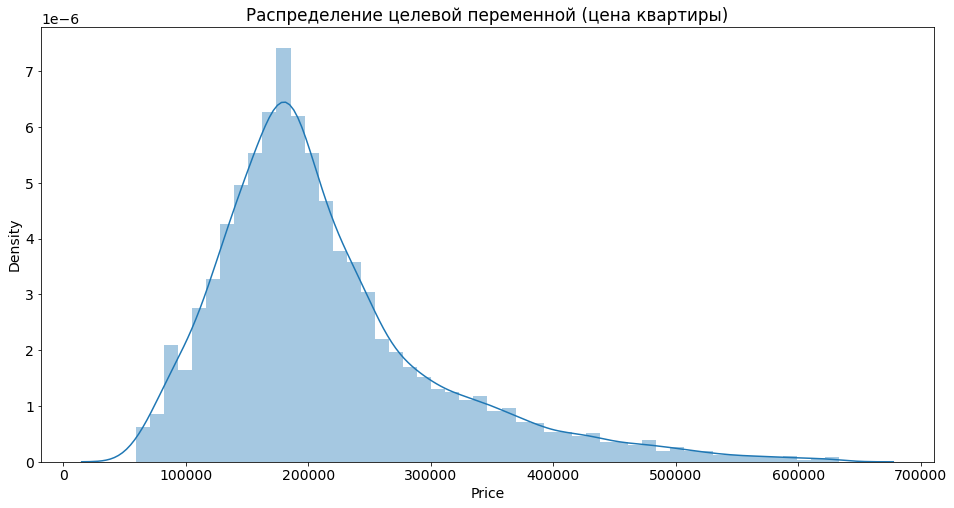

In [8]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)

plt.title('Распределение целевой переменной (цена квартиры)')
plt.show()

## Обработка данных и генерация новых признаков

In [9]:
class DataPreprocessor:
    def __init__(self):
        self.mode_rooms = None
        self.mode_square = None
        self.mode_life_square = None
        self.mode_house_year = None
        self.median_house_floor = None
        self.median_ecology_1 = None
        self.median_healthcare_1 = None
        self.median_kitchen_square = None
        self.districts_healthcare = None


        
    def fit(self, df):
        # Расчет мод и медиан
        self.mode_rooms = df['Rooms'].mode()[0]
        self.mode_square = df['Square'].mode()[0]
        self.mode_life_square = df['LifeSquare'].mode()[0]
        self.mode_house_year = df['HouseYear'].mode()[0]
        self.median_house_floor = df['HouseFloor'].median()
        self.median_ecology_1 = df['Ecology_1'].median()
        self.median_healthcare_1 = df['Healthcare_1'].median()
        self.median_kitchen_square = df['KitchenSquare'].median()
              
        # Среднее значние Helthcare_1 в каждом районе
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()


    def transform(self, df):
        
        # Пропуски
        df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = self.mode_life_square
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = self.median_healthcare_1

        # Rooms
        df.loc[(df['Rooms'] > 5) | (df['Rooms'] < 1), 'Rooms'] = self.mode_rooms
        
        # Обработка площадей
        df['Square'] = df['Square'].apply(np.ceil)
        df['LifeSquare'] = df['LifeSquare'].apply(np.ceil)
        df['KitchenSquare'] = df['KitchenSquare'].apply(np.ceil)
        df.loc[(df['Square'] > 300) | (df['Square'] < 10), 'Square'] = self.mode_square
        df.loc[(df['LifeSquare'] > 300) | (df['LifeSquare'] < 8), 'LifeSquare'] = self.mode_life_square
        df.loc[(df['KitchenSquare'] > 30) | (df['KitchenSquare'] < 4), 'KitchenSquare'] = self.median_kitchen_square
        
        # Обработка этажей
        df.loc[(df['HouseFloor'] > 50) | (df['HouseFloor'] < 1), 'HouseFloor'] = self.median_house_floor
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        # Обработка года
        current_year = datetime.now().year
        df.loc[df['HouseYear'] > current_year, 'HouseYear'] = self.mode_house_year

        # Обработка категорий
        df.replace({'Shops_2': {'A': 1}}, inplace=True)
        df.replace({'Shops_2': {'B': 0}}, inplace=True)
        
        # Обработка экологии
        df.loc[df['Ecology_1'] == 0, 'Ecology_1'] = self.median_ecology_1
        
       
        # Удаляем Id и ненужные признаки
        df.drop(['Id'], axis=1, inplace=True)
        df.drop(['Ecology_2'], axis=1, inplace=True)
        df.drop(['Ecology_3'], axis=1, inplace=True)

        return df

In [10]:
class FeatureGenerator:
    def __init__(self):
        self.DistrictId_counts = None
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.district_size = None

        
         
    def fit(self, X):
        
        # размера района
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # средний возраст района
        self.districts_median_year = X.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict() 
        
        # средняя площадь квартиры в районе
        self.districts_density = X.groupby(['DistrictId'])['Square'].agg('median').to_dict() 
        
        # средняя цена за квадратный метр площади в районе
        self.district_price_per_square = X.groupby(['DistrictId'])['Price'].agg('median')\
        / X.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district
        
        # добавление категорий по возрасту дома и по этажу
        X = self.year_to_cat(X)
        X = self.floor_to_cat(X)


        
    def new_features(self, X):
        
        # добавление категорий по возрасту дома и по этажу
        X = self.year_to_cat(X)
        X = self.floor_to_cat(X)
        
        # размер района
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        X['DistrictSize'].fillna(5, inplace=True)
                
        # Средний возраст района     
        X['DistrictYear'] = X['DistrictId'].map(self.districts_median_year)
        self.DistrictYear_median = X['DistrictYear'].median()
        X['DistrictYear'].fillna(self.DistrictYear_median, inplace=True)

        # Средняя площадь квартиры в районе
        X['DistrictDensity'] = X['DistrictId'].map(self.districts_density)
        self.DistrictDensity_median = X['DistrictDensity'].median()
        X['DistrictDensity'].fillna(self.DistrictDensity_median, inplace=True)

        # Средняя цена за квадратный метр в каждом районе
        self.district_price_per_square.to_dict()
        X['DistrictPrice'] = X['DistrictId'].map(self.district_price_per_square)
        self.DistrictPrice_median = X['DistrictPrice'].median()
        X['DistrictPrice'].fillna(self.DistrictPrice_median, inplace=True)
             
        return X
            

    def floor_to_cat(self, X):
        """Категория по этажу"""
        
        X['floor_cat'] = 0
        X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
        return X
     
    def year_to_cat(self, X):
        """Категория по году дома"""
        
        X['year_cat'] = 0
        X.loc[X['HouseYear'] <= 1940, 'year_cat'] = 1
        X.loc[(X['HouseYear'] > 1940) & (X['HouseYear'] <= 1950), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1950) & (X['HouseYear'] <= 1960), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1960) & (X['HouseYear'] <= 1970), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 1970) & (X['HouseYear'] <= 1980), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 1990), 'year_cat'] = 6
        X.loc[(X['HouseYear'] > 1990) & (X['HouseYear'] <= 2000), 'year_cat'] = 7
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 8
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 9
        return X


## Обработка данных, очистка, исправление выбросов

In [11]:
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

## Добавление новых признаков

In [12]:
features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.new_features(train_df)
test_df = features_gen.new_features(test_df)

## Разделение данных на тренировочную и тестовую последовательность

In [13]:
y = pd.DataFrame(data=train_df['Price'])
train_df.drop('Price', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=42)

## В качестве модели выбрана - Gradient Boosting Regressor

In [14]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=4,
                                        random_state=42,
                                        n_estimators=200)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)


In [15]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### Оценим работу модели на тренировачных значениях

R2:	0.898
RMSE:	29447.208
MSE:	867138056.663


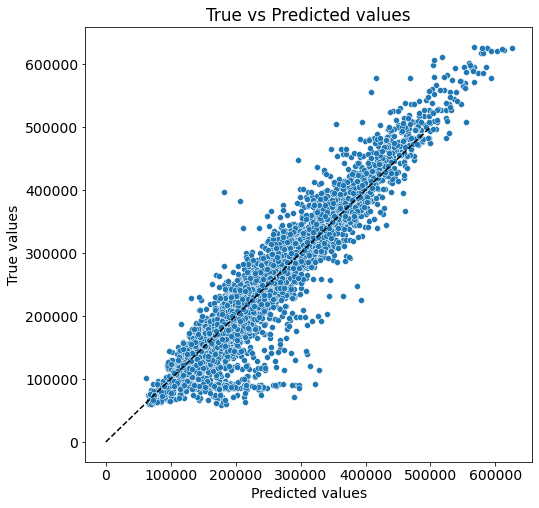

In [16]:
evaluate_preds(y_train['Price'], y_train_preds)

### И на тестовых:

R2:	0.773
RMSE:	45507.667
MSE:	2070947771.557


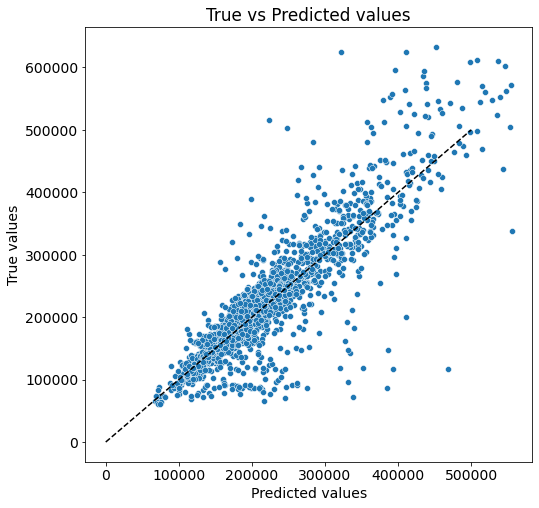

In [17]:
evaluate_preds(y_test['Price'], y_test_preds)

## Список признаков, сортированный по их важности от большего к меньшему

In [18]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
2,Square,0.435824
22,DistrictPrice,0.350856
1,Rooms,0.025888
4,KitchenSquare,0.023399
7,HouseYear,0.023270
6,HouseFloor,0.015618
9,Social_1,0.014365
11,Social_3,0.012713
20,DistrictYear,0.012386
10,Social_2,0.010790


In [19]:
submit = pd.read_csv('./sample_submission.csv')

In [20]:
submit.head(5)

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [21]:
predictions = gb_model.predict(test_df)

In [22]:
submit['Price'] = predictions

### Файл для загрузки на kuggle

In [23]:
submit.to_csv('gb_submit.csv', index=False)